In [1]:
%matplotlib inline

import numpy as np
import seaborn as sns
sns.set(style='whitegrid')
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import datasets

#### Read in the data

In [2]:
# Load the data
# iris.data = [(Sepal Length, Sepal Width, Petal Length, Petal Width)]
irisdataset = datasets.load_iris()

In [3]:
x_vals = irisdataset.data
y_vals = irisdataset.target

In [4]:
x_vals[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [5]:
y_vals

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [6]:
iris = pd.DataFrame(x_vals,columns=["SepalLengthCm", "SepalWidthCm" , "PetalLengthCm", "PetalWidthCm"])
iris["CategoryId"] = y_vals
names={0:"Setosa",1:"Versicolour",2:"Virginica"}
iris["IdLabels"] = iris["CategoryId"].replace(names,inplace=False)
iris.sample(8,replace=True)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,CategoryId,IdLabels
10,5.4,3.7,1.5,0.2,0,Setosa
113,5.7,2.5,5.0,2.0,2,Virginica
116,6.5,3.0,5.5,1.8,2,Virginica
82,5.8,2.7,3.9,1.2,1,Versicolour
62,6.0,2.2,4.0,1.0,1,Versicolour
0,5.1,3.5,1.4,0.2,0,Setosa
114,5.8,2.8,5.1,2.4,2,Virginica
93,5.0,2.3,3.3,1.0,1,Versicolour


In [7]:
print(iris.shape)
print(iris["IdLabels"].value_counts())

(150, 6)
Virginica      50
Setosa         50
Versicolour    50
Name: IdLabels, dtype: int64


### Pick Two Categories for binary classification
* There are 50 from each category, and the dataset is already sorted, so we keep the first 100 rows of data
* The Setosa iris species is linearly separable from the other two, but Virginica and Versicolor are not linearly separable from each other, so we'll compare Setosa vs Versicolour and then Versicolour vs Virginica.

In [8]:
iris = iris[:100]

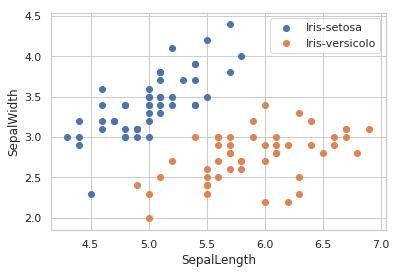

In [9]:
# Note there are 50 from each category in the dataset
plt.scatter(iris[:50].SepalLengthCm, iris[:50].SepalWidthCm, label='Iris-setosa')
plt.scatter(iris[51:].SepalLengthCm, iris[51:].SepalWidthCm, label='Iris-versicolo')
plt.xlabel('SepalLength')
plt.ylabel('SepalWidth')
plt.legend(loc='best')

### Create X and y values

In [10]:
X = iris.drop(labels=['CategoryId', 'IdLabels'], axis=1).values
y = iris["CategoryId"]

# Set random seed for numpy and tensorflow for reproducible results
seed = 12
np.random.seed(seed)
tf.set_random_seed(seed)

#### Split data into train and test sets
* We will be randomizing the data with `train_index` since the dataset is categegorized
* In `np.random.choice` we set `replace=False` to avoid double-sampling

In [11]:
# The percent of our data we want to use for training data
train_pct = 0.8

train_index = np.random.choice(len(X), round(len(X) * train_pct), replace=False)
test_index = np.array(list(set(range(len(X))) - set(train_index)))
train_X = X[train_index]
train_y = y[train_index]
test_X = X[test_index]
test_y = y[test_index]

In [12]:
print(type(train_X),type(test_X),type(train_y),type(test_y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


#### Normalize the data
* For logistic regression, normalization isn't strictly required
* The main goal of normalizing features is to help convergence during optimization.
* Remember that in logistic regression your coefficients indicate the effect of a one-unit change in your predictor variable on the log odds of 'success'. 
* The effect of transforming a variable (such as by standardizing or normalizing) is to change what we are calling a 'unit' in the context of our model. 
* The raw x data varies across some number of units in its original form. 
* After you normalize, your data ranges from **`0` to `1`**. 
* So now a change of one unit means going from the lowest valued observation to the highest valued observation. 
* The amount of increase in the log odds of success has not changed. 
* But we **DO** need to normalize for other machine learning algorithms, such as LASSO or ridge regression (because they put constraints on the size of the coefficients associated to each variable).
* As we will see later, when we talk more extensively about batch normalization, this can be very important for neural networks as well.

In [13]:
# Define function to normalize the data
def min_max_normalized(data):
    col_max = np.max(data, axis=0)
    col_min = np.min(data, axis=0)
    return np.divide(data - col_min, col_max - col_min)

# Normalized processing, must be placed after the data set segmentation, 
# otherwise the test set will be affected by the training set
train_X = min_max_normalized(train_X)
test_X = min_max_normalized(test_X)

### Build the model
* Begin building the model framework
* Declare the variables that need to be learned (i.e. weights and biases)
* Make sure to give your variables the right shape - you will be able to figure this out from how many features there are
* There are 4 features here, A's dimension is (4, 1)

In [15]:
### YOUR CODE HERE

### Define the placeholders for our data
* You will need placeholders for the features and labels.
* Be sure to declare a data type, and the appropriate shape.

In [16]:
### YOUR CODE HERE

### Declare the operations for the model that you need to learn
* In this case we are doing logistic regression, so remember that the formula is:

$$\Large{ \textbf{y} = \sigma(\textbf{A}\times \textbf{x} + \textbf{b})}$$

* Where $\sigma$ is the sigmoid function
* Keep in mind that we will be doing the sigmoid operation as part of our loss function, so we don't need to do it twice.

In [17]:
### YOUR CODE HERE
model_output = 

### Declare a loss function
* Use the sigmoid cross entropy loss function `tf.nn.sigmoid_cross_entropy_with_logits`

In [18]:
### YOUR CODE HERE

### Define the learning rate,  batch size, and the number of iterations you will run

In [19]:
learning_rate = 0.003
batch_size = 30
iter_num = 2400

### Define the optimizer
* Use `tf.train.GradientDescentOptimizer`

In [20]:
### YOUR CODE HERE

### Define your training step
* This is the **goal** of the learning/optimization process - i.e. what are we doing with loss function?

In [1]:
### YOUR CODE HERE

### Define the accuracy

In [22]:
# The default threshold is 0.5, rounded off directly
prediction = tf.round(tf.sigmoid(model_output))
# Bool into float32 type
correct = tf.cast(tf.equal(prediction, target), dtype=tf.float32)
# Average
accuracy = tf.reduce_mean(correct)

### Train the model
You will need to do the following:
1. Set up a training session
2. Initialize variables
3. Evaluate your training step, accuracy, and loss at each epoch.
4. Store the results

In [23]:
print(type(train_X),type(test_X),type(train_y),type(test_y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [24]:
train_y=np.array(train_y)
print(train_X.shape,train_y.shape)

(80, 4) (80,)


In [25]:
np.random.choice(train_y,size=20)

array([1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1])

In [26]:
# Start training model
# Define the variable that stores the result
loss_trace = []
train_acc = []
test_acc = []

# Set up a session and initialize variables
### YOUR CODE HERE

# training model
for epoch in range(iter_num):
    # Generate random batch index
    batch_index = np.random.choice(len(train_X), size=batch_size)
    batch_train_X = train_X[batch_index]
    batch_train_y = np.transpose([train_y[batch_index]])
    
    # Evaluate your training step, accuracy, and loss at each epoch.
    ### YOUR CODE HERE
    temp_loss = 
    temp_train_acc = 
    temp_test_acc = 

    # store the results
    ### YOUR CODE HERE

    
    # output
    if (epoch + 1) % 300 == 0:
        print('epoch: {:4d} loss: {:5f} train_acc: {:5f} test_acc: {:5f}'.format(epoch + 1, temp_loss,
                                                                          temp_train_acc, temp_test_acc))
        
sess.close()

epoch:  300 loss: 0.688184 train_acc: 0.525000 test_acc: 0.400000
epoch:  600 loss: 0.682965 train_acc: 0.525000 test_acc: 0.400000
epoch:  900 loss: 0.694109 train_acc: 0.525000 test_acc: 0.400000
epoch: 1200 loss: 0.492411 train_acc: 0.525000 test_acc: 0.400000
epoch: 1500 loss: 0.591237 train_acc: 0.550000 test_acc: 0.550000
epoch: 1800 loss: 0.508848 train_acc: 0.687500 test_acc: 0.800000
epoch: 2100 loss: 0.390069 train_acc: 0.850000 test_acc: 1.000000
epoch: 2400 loss: 0.484044 train_acc: 0.912500 test_acc: 1.000000


### Visualize the results

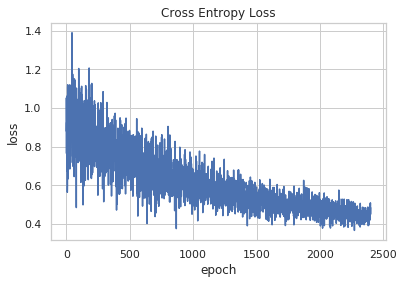

In [27]:
plt.plot(loss_trace)
plt.title('Cross Entropy Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

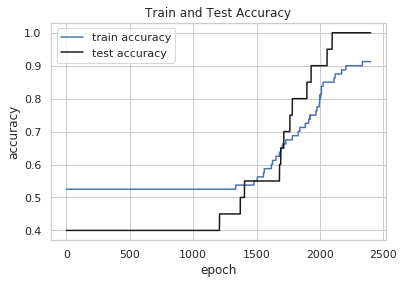

In [28]:
# accuracy
plt.plot(train_acc, 'b-', label='train accuracy')
plt.plot(test_acc, 'k-', label='test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train and Test Accuracy')
plt.legend(loc='best')
plt.show()